<a href="https://colab.research.google.com/github/DimitriLeandro/DA2Group10/blob/main/pretrained_satellighte_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading datasets and importing libs

In [ ]:
!pip install satellighte

In [1]:
import imageio
import satellighte as sat
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch
import torchmetrics as tm
import pytorch_lightning as pl
from PIL import Image
from torch import flatten
from torchvision import transforms as tt
from torchvision.transforms.transforms import Resize
from torch.utils.data import DataLoader, random_split

In [2]:
!wget -q https://uni-muenster.sciebo.de/s/KNjoOrXdWecbvdh/download?path=%2F&files=training_patches.zip
!unzip -qq /content/download?path=%2F
!unzip -qq /content/task_2/training_patches.zip
!unzip -qq /content/task_2/unlabeled_training_data.zip
!unzip -qq /content/task_2/validation_data.zip

## Mounting drive to save model checkpoints

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Loading pretrained model

In [ ]:
sat.available_models()

['efficientnet_b0_eurosat', 'mobilenetv2_default_eurosat']

In [5]:
model_name = 'mobilenetv2_default_eurosat'
model = sat.Classifier.from_pretrained(
  model_name, 
  sat.get_model_latest_version(model_name)
)

Downloading: "https://github.com/canturan10/satellighte/releases/download/v0.0.11/mobilenetv2_default_eurosat.pth" to /usr/local/lib/python3.7/dist-packages/satellighte/models/mobilenetv2_default_eurosat/v1/mobilenetv2_default_eurosat.pth
100%|██████████| 8.77M/8.77M [00:00<00:00, 104MB/s]


In [ ]:
img_urls = [
  'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/AnnualCrop.jpg',
  'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/Forest.jpg',
  'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/HerbaceousVegetation.jpg',
  'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/PermanentCrop.jpg',
  'https://raw.githubusercontent.com/canturan10/satellighte/master/src/eurosat_samples/River.jpg'
]

for img_url in img_urls:
  img = imageio.imread(img_url)
  results = model.predict(img)
  plt.imshow(img)
  plt.show()
  print(img_url.split('/')[-1])
  print(results, '\n\n')

## Image transformers

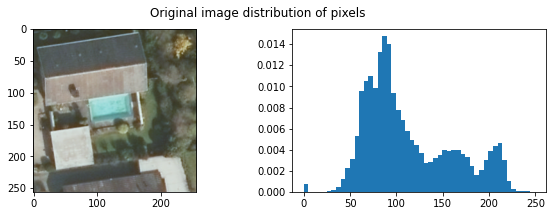

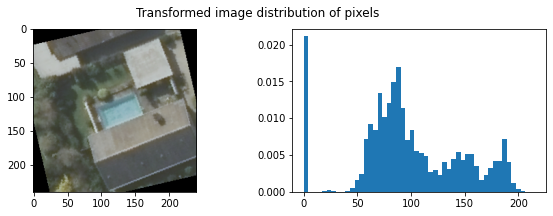

In [46]:
# this method sets model.mean and model.std
model.configure_preprocess()

# input size of images
input_size = (240, 240)

# creating a preprocessing + data augmentation unit for the training data
train_tt = tt.Compose([
  tt.Resize(input_size),
  tt.ColorJitter(brightness=0.15, contrast=0.33, saturation=0.2, hue=0.05),
  tt.RandomRotation(degrees=15),
  tt.RandomHorizontalFlip(p=0.5),
  tt.RandomVerticalFlip(p=0.5),
  # tt.GaussianBlur(kernel_size=(5, 9), sigma=(0.01, 0.1)),
  # tt.RandomPerspective(distortion_scale=0.1, p=0.2),
  # tt.RandomPosterize(bits=2),
])

# creating a preprocessing unit for the validation data
val_tt = tt.Compose([
  tt.Resize(input_size)
])

# loading an image sample
img = Image.open('/content/training_patches/pools/4B37MU.png')

# lets have a look at the original image and its pixels values distribution
plt.rcParams['figure.figsize'] = (10,3)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[1].hist(np.asarray(img).ravel(), bins=50, density=True)
plt.suptitle('Original image distribution of pixels')
plt.show()

# using the preprocessing operations to transform the image to a pytorch tensor
img_tt = train_tt(img)
 
# lets have a look at the trasnformed image and its pixels values distribution
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_tt)
axs[1].hist(np.asarray(img_tt).ravel(), bins=50, density=True)
plt.suptitle('Transformed image distribution of pixels')
plt.show()

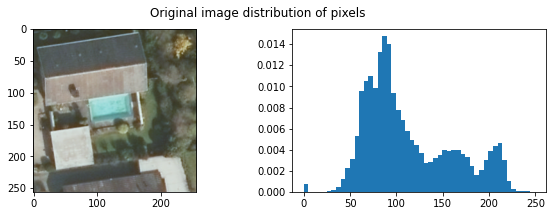

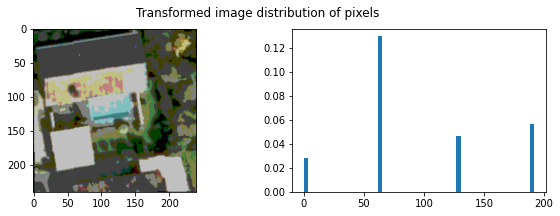

In [ ]:
# loading an image sample
img = Image.open('/content/training_patches/pools/4B37MU.png')

# lets have a look at the original image and its pixels values distribution
plt.rcParams['figure.figsize'] = (10,3)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[1].hist(np.asarray(img).ravel(), bins=50, density=True)
plt.suptitle('Original image distribution of pixels')
plt.show()

# using the preprocessing operations to transform the image to a pytorch tensor
img_tt = train_tt(img)
 
# lets have a look at the trasnformed image and its pixels values distribution
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_tt)
axs[1].hist(np.asarray(img_tt).ravel(), bins=50, density=True)
plt.suptitle('Transformed image distribution of pixels')
plt.show()

## Hyperparameters

In [ ]:
hparams = {
  'learning_rate': 1e-2,
  'momentum':      0.9,
  'weight_decay':  3e-4,
  'gamma':         0.5,
  'ratio':         10,
  'milestones':    [1, 10, 100],
  'max_epoch':     10,
  'batch_size':    64,
  'criterion':     'cross_entropy',
  'optimizer':     'adam',
  'device':        torch.cuda.current_device(),
}

## Loading dataset

In [ ]:
# Load datasets from the sat.dataset module
train_ds = sat.datasets.EuroSAT(
  phase="train",
  transforms=train_tt,
)
val_ds = sat.datasets.EuroSAT(
  phase="val",
  transforms=val_tt,
)

# spliting datasets to get just a few samples
tr_split_len  = 1000
val_split_len = 100
part_tr  = random_split(train_ds, [tr_split_len, len(train_ds)-tr_split_len])[0]
part_val = random_split(val_ds, [val_split_len, len(val_ds)-val_split_len])[0]

# Create a DataLoader for training and validation
train_dl = DataLoader(
  part_tr,
  batch_size=hparams.get('batch_size'),
  shuffle=True,
)
val_dl = DataLoader(
  part_val,
  batch_size=hparams.get('batch_size'),
  shuffle=False,
)

## Training the model

In [ ]:
# adding the metric we'd like to measure while the epochs go on
model.add_metric(
  'balanced_accuracy',
  tm.Accuracy(
    num_classes = len(train_ds.classes),
    average     = 'weighted'
  )
)

In [ ]:
 # define checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
  dirpath='/content/drive/MyDrive/task_2_models_checkpoint',  # Path to save the model
  verbose=True,  # Whether to print information about the model checkpointing
  filename='task_2_model_checkpoint',  # Filename to save the model
  monitor='metrics/balanced_accuracy',  # Quantity to monitor
  save_top_k=3,  # Number of models to keep
  mode='max',  # Save max metric value
)

In [ ]:
# define trainer
trainer = pl.Trainer(
  default_root_dir=".",  # Default path for logs and weights
  accumulate_grad_batches=4,  # Accumulates grads every k batches
  callbacks=[
    checkpoint_callback,
    pl.callbacks.RichProgressBar(),
  ],  # Callback for checkpointing
  accelerator='gpu',
  gpus=hparams.get('device'),  # GPU device
  max_epochs=hparams.get('max_epoch'),  # Stop training once this number of epochs is reached
  check_val_every_n_epoch=1,  # Check validation every n train epochs.
  deterministic=True,  # Set to True to disable randomness in the model
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
for parameter in model.parameters():
  parameter.requires_grad = False

for parameter in model.model.backbone.classifier.parameters():
  parameter.requires_grad = True

In [ ]:
# fit the model
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=[val_dl])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type        ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ MobileNetV2 │  2.2 M │
└───┴───────┴─────────────┴────────┘

Trainable params: 12.8 K                                                                     
Non-trainable params: 2.2 M                                                                  
Total params: 2.2 M                                                                          
Total estimated model params size (MB): 8

Output()

Epoch 0, global step 32: 'metrics/balanced_accuracy' reached 0.75000 (best 0.75000), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint.ckpt' as top 3
Epoch 1, global step 64: 'metrics/balanced_accuracy' reached 0.74000 (best 0.75000), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint-v1.ckpt' as top 3
Epoch 2, global step 96: 'metrics/balanced_accuracy' reached 0.85000 (best 0.85000), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint-v2.ckpt' as top 3
Epoch 3, global step 128: 'metrics/balanced_accuracy' was not in top 3
Epoch 4, global step 160: 'metrics/balanced_accuracy' was not in top 3
Epoch 5, global step 192: 'metrics/balanced_accuracy' reached 0.85000 (best 0.85000), saving model to '/content/drive/MyDrive/task_2_models_checkpoint/task_2_model_checkpoint-v1.ckpt' as top 3
Epoch 6, global step 224: 'metrics/balanced_accuracy' reached 0.75000 (best 0.85000), saving